In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
pd.options.display.max_rows = 10
pd.options.display.max_columns = 500

In [2]:
###
## Load dataframe where each row is a single applicant
###

df = pd.read_csv('./df_test.csv')
df['ml_outcomes'] = df['ml_outcomes_div'].round(2)# + df['R']*0.13
#df['T'] = df['T'].round(2)#


In [3]:
df['ml_outcomes'].describe()

count    1000000.000000
mean           0.524595
std            0.197813
min            0.030000
25%            0.390000
50%            0.510000
75%            0.660000
max            1.240000
Name: ml_outcomes, dtype: float64

In [4]:
df['T']

0         67
1         46
2         79
3         45
4         63
          ..
999995    48
999996    39
999997    51
999998    43
999999    44
Name: T, Length: 1000000, dtype: int64

In [5]:
FRAC_ADMIT = df[['A']].sum()/len(df)


In [6]:
FRAC_ADMIT

A    0.369469
dtype: float64

In [7]:
len(df)

1000000

<AxesSubplot:>

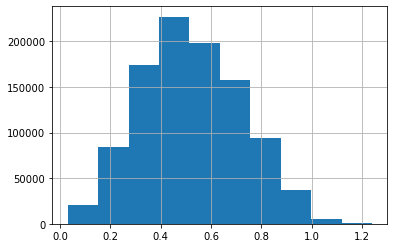

In [8]:
df['ml_outcomes'].hist()

In [9]:
##
# R = race, T = test score, ml_outcomes = expected utility from admitting, 
# ml_outcomes_{} counterfactual utility given race 
##

df[['R','T','ml_outcomes','T_black','T_white','ml_outcomes_black','ml_outcomes_white','ml_outcomes_decision','B_p']].sort_values(by='ml_outcomes')



,R,T,ml_outcomes,T_black,T_white,ml_outcomes_black,ml_outcomes_white,ml_outcomes_decision,B_p
261180,0,12,0.03,9,12,-3.825614,-3.372248,0,0
275905,0,11,0.03,8,11,-3.904445,-3.451079,0,0
601095,0,10,0.03,11,10,-3.667952,-3.529910,0,0
32461,0,12,0.03,8,12,-3.904445,-3.372248,0,0
489547,0,12,0.03,10,12,-3.746783,-3.372248,0,0
...,...,...,...,...,...,...,...,...,...
897432,1,106,1.23,106,121,3.820987,5.220324,1,1
992959,1,107,1.23,107,124,3.899818,5.456817,1,1
934719,1,107,1.23,107,124,3.899818,5.456817,1,1
454722,1,105,1.23,105,120,3.742157,5.141493,1,1


In [10]:
#df['ml_outcomes'] = df['ml_outcomes'] + 1*df['R']

In [11]:
###
## Get total utility from admitting people in a stratum 
###

df_ = df[['R','T','ml_outcomes']].groupby(['R','T']).sum().reset_index()

In [12]:
###
## Get number of people in each stratum
###

df_count = df[['R','T','ml_outcomes']].groupby(['R','T']).count().reset_index()
df_count.columns = ['R','T','Count']
df_count['N'] = df_count['Count']

In [13]:
###
## Merge summary tables to get one table with Race, Test Score, SUM(Utility), COUNT(applicants) per stratum
###

dff = df_.merge(df_count[['N']],left_index=True,right_index=True).sort_values(by='ml_outcomes',ascending=False).reset_index().sort_values(by='index').reset_index()

In [14]:
# final info table
dff.sort_values(by='ml_outcomes')

,level_0,index,R,T,ml_outcomes,N
1,221,1,0,11,0.03,1
0,220,0,0,10,0.09,3
2,219,2,0,12,0.21,7
120,218,120,1,7,0.27,1
119,217,119,1,6,0.27,1
...,...,...,...,...,...,...
46,4,46,0,56,10859.68,20884
50,3,50,0,60,10907.40,18179
49,2,49,0,59,11000.28,18966
47,1,47,0,57,11008.98,20387


### Setup optimization problem 

In [15]:
from ortools.linear_solver import pywraplp


In [16]:
solver = pywraplp.Solver.CreateSolver('GLOP')


In [17]:
dff

,level_0,index,R,T,ml_outcomes,N
0,220,0,0,10,0.09,3
1,221,1,0,11,0.03,1
2,219,2,0,12,0.21,7
3,216,3,0,13,0.48,12
4,215,4,0,14,0.48,12
...,...,...,...,...,...,...
217,187,217,1,105,3.69,3
218,202,218,1,106,1.23,1
219,193,219,1,107,2.46,2
220,201,220,1,108,1.23,1


In [18]:
applicant_stratum = []
vars_cache = {}

# Objective: Maximize the expected utility of the admitted students
objective = solver.Objective()

# For each stratum
for ix, row in dff.iterrows():
    # probability of admission
    numvar = solver.NumVar(0.0, 1.0, str(ix))
    
    # store variable by index, and also by stratum R, T
    applicant_stratum.append(numvar)
    vars_cache[(row['R'],row['T'])] = numvar
    
    # Benefit of admitting people is total utility in that stratum
    objective.SetCoefficient(applicant_stratum[ix], float(row['ml_outcomes']))
objective.SetMaximization()


In [19]:
# Currently we have no constraints 
solver.NumConstraints()

0

In [20]:
# Constraint: At most K applicants
K = int(len(df)*FRAC_ADMIT)
print(K)
admit_quota = solver.Constraint(0, K)

# Total admits cannot exceed K 
for ix, row in dff.iterrows():
    admit_quota.SetCoefficient(applicant_stratum[ix], float(row['N']))

369469


In [21]:
# Now we have one constraint
solver.NumConstraints()

1

## Add Equalized Odds Constraints

In [22]:
from collections import Counter

def convertListToProb(raw_list):
    counts = dict(Counter(raw_list))
    probs = {}
    for test_score in counts:
        probs[test_score]  = counts[test_score]/float(len(raw_list))
    return [(probs[t], t) for t in probs]

In [23]:
T_blacks_list = df[df['R']==0][['T','T_black']].groupby('T')['T_black'].apply(list).reset_index(name='T_blacks')
T_blacks_list['probs'] = T_blacks_list['T_blacks'].apply(convertListToProb)
didntexist = 0
exists = 0
for ix, row in T_blacks_list.iterrows():
    cf_fair_stratum = solver.Constraint(0.0, 0.0)

    White_T = row['T']
    Blacks_Ts = row['probs']        
    cf_fair_stratum.SetCoefficient(vars_cache[(0.0, White_T)], -1.0)
    for prob in Blacks_Ts:
        if (1.0, prob[1]) not in vars_cache:
            vars_cache[(1.0, prob[1])] = solver.NumVar(0.0, 1.0, str((1.0, prob[1])))
            didntexist+=1
        else:
            exists+=1
        cf_fair_stratum.SetCoefficient(vars_cache[(1.0, prob[1])], prob[0])
didntexist,exists

(4, 959)

In [24]:
T_whites_list = df[df['R']==1][['T','T_white']].groupby('T')['T_white'].apply(list).reset_index(name='T_whites')
T_whites_list['probs'] = T_whites_list['T_whites'].apply(convertListToProb)
didntexist = 0
exists = 0

for ix, row in T_whites_list.iterrows():
    cf_fair_stratum = solver.Constraint(0.0, 0.0)

    Black_T = row['T']
    White_Ts = row['probs']
    
    cf_fair_stratum.SetCoefficient(vars_cache[(1.0, Black_T)], -1.0)
    for prob in White_Ts:
        if (0.0, prob[1]) not in vars_cache:
            vars_cache[(0.0, prob[1])] = solver.NumVar(0.0, 1.0, str((0.0, prob[1])))
            didntexist+=1
        else:
            exists+=1
            
        cf_fair_stratum.SetCoefficient(vars_cache[(0.0, prob[1])], prob[0])
didntexist,exists  

(1, 897)

In [25]:
solver.NumConstraints()

223

## Solve linear program

In [26]:
solver.ABNORMAL

4

In [27]:
status = solver.Solve()


In [28]:
status

0

In [29]:
solver.OPTIMAL

0

In [30]:
row = []
admit = []

for i in applicant_stratum:
    row.append(int(str(i)))
    admit.append(i.solution_value())

df_decisions = pd.DataFrame({'row_id':row,'decision':admit})

In [31]:
df_decisions

,row_id,decision
0,0,0.369460
1,1,0.369460
2,2,0.369460
3,3,0.369460
4,4,0.369460
...,...,...
217,217,0.656069
218,218,0.828034
219,219,0.828034
220,220,0.828034


In [32]:
dff.merge(df_decisions,left_index=True,right_index=True).sort_values(by='ml_outcomes',ascending=False)

,level_0,index,R,T,ml_outcomes,N,row_id,decision
48,0,48,0,58,11182.64,19969,48,0.36946
47,1,47,0,57,11008.98,20387,47,0.36946
49,2,49,0,59,11000.28,18966,49,0.36946
50,3,50,0,60,10907.40,18179,50,0.36946
46,4,46,0,56,10859.68,20884,46,0.36946
...,...,...,...,...,...,...,...,...
119,217,119,1,6,0.27,1,119,0.36946
120,218,120,1,7,0.27,1,120,0.36946
2,219,2,0,12,0.21,7,2,0.36946
0,220,0,0,10,0.09,3,0,0.36946


In [33]:
xxx_ = dff.merge(df_decisions,left_index=True,right_index=True).sort_values(by='ml_outcomes',ascending=False)
xxx_.sort_values(by='T')

,level_0,index,R,T,ml_outcomes,N,row_id,decision
119,217,119,1,6,0.27,1,119,0.369460
120,218,120,1,7,0.27,1,120,0.369460
121,214,121,1,8,0.54,2,121,0.369460
122,212,122,1,9,0.81,3,122,0.369460
0,220,0,0,10,0.09,3,0,0.369460
...,...,...,...,...,...,...,...,...
114,209,114,0,124,1.00,1,114,0.828034
115,208,115,0,125,1.00,1,115,0.828034
116,207,116,0,127,1.00,1,116,1.000000
117,206,117,0,129,1.00,1,117,1.000000


In [34]:
xxx = dff.merge(df_decisions,left_index=True,right_index=True).sort_values(by='ml_outcomes',ascending=False)
xxx

,level_0,index,R,T,ml_outcomes,N,row_id,decision
48,0,48,0,58,11182.64,19969,48,0.36946
47,1,47,0,57,11008.98,20387,47,0.36946
49,2,49,0,59,11000.28,18966,49,0.36946
50,3,50,0,60,10907.40,18179,50,0.36946
46,4,46,0,56,10859.68,20884,46,0.36946
...,...,...,...,...,...,...,...,...
119,217,119,1,6,0.27,1,119,0.36946
120,218,120,1,7,0.27,1,120,0.36946
2,219,2,0,12,0.21,7,2,0.36946
0,220,0,0,10,0.09,3,0,0.36946


In [35]:
len(xxx_)

222

In [36]:
xxx.to_csv('./decision.csv')

In [37]:
solution = pd.read_csv('./decision.csv')

In [38]:
xxx

,level_0,index,R,T,ml_outcomes,N,row_id,decision
48,0,48,0,58,11182.64,19969,48,0.36946
47,1,47,0,57,11008.98,20387,47,0.36946
49,2,49,0,59,11000.28,18966,49,0.36946
50,3,50,0,60,10907.40,18179,50,0.36946
46,4,46,0,56,10859.68,20884,46,0.36946
...,...,...,...,...,...,...,...,...
119,217,119,1,6,0.27,1,119,0.36946
120,218,120,1,7,0.27,1,120,0.36946
2,219,2,0,12,0.21,7,2,0.36946
0,220,0,0,10,0.09,3,0,0.36946


In [39]:
(xxx['ml_outcomes']*xxx['decision']).sum()

193826.79981520315

In [40]:
def maxMLOutcomes(frac_black=0.01):
    black_admits = int(K*frac_black)
    white_admits = int(K*(1-frac_black))
    
    b = df[df['R']==1].sort_values(by='ml_outcomes',ascending=False).head(n=black_admits)
    w = df[df['R']==0].sort_values(by='ml_outcomes',ascending=False).head(n=white_admits)
    
    return b['B_p'].sum() + w['B_p'].sum()    

In [41]:
def maxMLOutcomesBlack(frac_black=0.01):
    black_admits = int(K*frac_black)
    white_admits = int(K*(1-frac_black))
    
    b = df[df['R']==1].sort_values(by='ml_outcomes',ascending=False).head(n=black_admits)
    w = df[df['R']==0].sort_values(by='ml_outcomes',ascending=False).head(n=white_admits)
    
    return b['B_p'].sum()   

In [42]:
df['key'] = df['R'].astype(str)+'_'+df['T'].astype(str)
xxx['key'] = xxx['R'].astype(str)+'_'+xxx['T'].astype(str)

In [43]:
len(xxx)

222

In [44]:
admit_decisions = df.merge(xxx,how='left',on='key')
admit_decisions['decision_random'] = pd.Series([random.random() for x in range(0,len(admit_decisions))]) < FRAC_ADMIT['A']


FRAC_BLACK_POLICY = (admit_decisions['R_y'] * admit_decisions['decision']).sum()/admit_decisions['decision'].sum()
SUM_BP_POLICY = ( admit_decisions['B_p'] * admit_decisions['decision']).sum()

FRAC_RANDOM_POLICY = (admit_decisions['R_y'] * admit_decisions['decision_random']).sum()/admit_decisions['decision_random'].sum()
SUM_BP_RAND_POLICY = ( admit_decisions['B_p'] * admit_decisions['decision_random']).sum()


In [45]:
file = open('./lp_results.csv','w')
file.write('{}\t{}\t{}\n'.format('Policy Name','Frac Diverse Candidates','Total Graduated'))
file.write('{}\t{}\t{}\n'.format('Random',str(FRAC_RANDOM_POLICY),str(SUM_BP_RAND_POLICY)))
file.write('{}\t{}\t{}\n'.format('Counterfactual Fairness',str(FRAC_BLACK_POLICY),str(SUM_BP_POLICY)))
file.close()


In [46]:
(xxx['N']*xxx['decision']).sum()/len(df)

0.36946900000000016